# train: fix
# test: mix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"
import seaborn as sns 
import ast
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings("ignore")

colors = ['black', '#8b0000', 'orange', '#5e81ac']
labels = ['participants', 'color', 'number', 'both']
from scipy.spatial.distance import correlation
from scipy.stats import spearmanr


In [2]:
output_dir = r"15_RL_agent_TDlearn_output_behavior_risk_dualQ"
os.makedirs(output_dir, exist_ok=True)


folder_path_participants = 'data_risk_added'
folder_path_colors = '11_RL_agent_TDlearn_output_risk_dualQ/model_behavior'
folder_path_numbers = '12_RL_agent_TDlearn_output_risk_dualQ/model_behavior'
folder_path_colors_numbers = '13_RL_agent_TDlearn_output_risk_dualQ/model_behavior'


df_participants = []
df_colors = []
df_numbers = []
df_colors_numbers = []


def find_matching_csv(folder_path, df_list):
            for csv_file in os.listdir(folder_path):
                if clean_name in csv_file and csv_file.endswith('.csv'):
                    csv_path = os.path.join(folder_path, csv_file)
                    df_csv = pd.read_csv(csv_path)
                    df_list.append(df_csv)





for file_name in os.listdir(folder_path_participants):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path_participants, file_name)
        df = pd.read_excel(file_path)
        df = df[df['outcome'].str.lower() != 'na'].reset_index(drop=True) 
        df_participants.append(df)

        clean_name = file_name.removeprefix("task_data_").removesuffix(".xlsx")


        find_matching_csv(folder_path_colors, df_colors)
        find_matching_csv(folder_path_numbers, df_numbers)
        find_matching_csv(folder_path_colors_numbers, df_colors_numbers)


In [3]:
for df in df_participants:
    df['block_type'] = None

    df.loc[df['block'] == 1, 'block_type'] = 'uniform'     # Block 1 is uni
    df.loc[df['block'] == 4, 'block_type'] = 'mix'     # Block 4 is mix

    # For blocks 2 and 3, set based on distribution
    df.loc[(df['block'] == 2) & (df['distribution'] == 'low'), 'block_type'] = 'low'
    df.loc[(df['block'] == 2) & (df['distribution'] == 'high'), 'block_type'] = 'high'
    df.loc[(df['block'] == 3) & (df['distribution'] == 'low'), 'block_type'] = 'low'
    df.loc[(df['block'] == 3) & (df['distribution'] == 'high'), 'block_type'] = 'high'
    

# adding myCard and youCard to the models dataset and also adding model_outcome

In [4]:
for i in range(len(df_participants)):
    myCard = df_participants[i]['myCard']
    yourCard = df_participants[i]['yourCard']
    distributions = df_participants[i]['distribution']
    block_type = df_participants[i]['block_type']
    
    for df_list in [df_colors, df_numbers, df_colors_numbers]:
        df_list[i]['myCard'] = myCard
        df_list[i]['yourCard'] = yourCard
        df_list[i]['distribution'] = distributions
        df_list[i]['block_type'] = block_type

# adding model outcome

In [5]:
for df in df_colors:
    outcomes = []
    for i in range(len(df)):
        my = df.loc[i, 'myCard']
        your = df.loc[i, 'yourCard']
        choice = df.loc[i, 'model_choices']
        
        if ((my > your and choice == 1) or (my < your and choice == 0)):
            outcomes.append('win')
        else:
            outcomes.append('lose')
    
    df['outcome'] = outcomes
    
    


for df in df_numbers:
    outcomes = []
    for i in range(len(df)):
        my = df.loc[i, 'myCard']
        your = df.loc[i, 'yourCard']
        choice = df.loc[i, 'model_choices']
        
        if ((my > your and choice == 1) or (my < your and choice == 0)):
            outcomes.append('win')
        else:
            outcomes.append('lose')
    
    df['outcome'] = outcomes
    
    

for df in df_colors_numbers:
    outcomes = []
    for i in range(len(df)):
        my = df.loc[i, 'myCard']
        your = df.loc[i, 'yourCard']
        choice = df.loc[i, 'model_choices']
        
        if ((my > your and choice == 1) or (my < your and choice == 0)):
            outcomes.append('win')
        else:
            outcomes.append('lose')
    
    df['outcome'] = outcomes

In [6]:
df_participants[2]

,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,risk,block_type
0,1067,uniform,894,win,3,9,4575,10.5,0,response,arrowdown,1,0,0.250,uniform
1,237,uniform,925,lose,2,1,1903,10.0,1,response,arrowdown,1,0,0.125,uniform
2,231,uniform,973,win,8,2,2130,10.5,2,response,arrowup,1,0,0.125,uniform
3,602,uniform,768,win,7,2,1537,11.0,3,response,arrowup,1,0,0.250,uniform
4,273,uniform,937,win,9,8,1809,11.5,4,response,arrowup,1,0,0.000,uniform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,567,high,787,win,9,7,2580,92.0,128,response,arrowup,4,0,0.000,mix
266,151,low,854,win,6,3,9541,92.5,89,response,arrowup,4,0,0.146,mix
267,178,low,863,win,8,5,1370,93.0,77,response,arrowup,4,0,0.023,mix
268,328,high,770,lose,6,4,1644,92.5,95,response,arrowdown,4,0,0.385,mix


In [7]:
df_colors[2]

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val,myCard,yourCard,distribution,block_type,outcome
0,0,0,10.5,10.5,"[[0.2421406975758025, 0.3926537297445585], [0....",3,9,uniform,uniform,win
1,0,0,10.0,10.0,"[[0.5964237985855667, 0.3926537297445585], [0....",2,1,uniform,uniform,lose
2,0,1,9.5,10.5,"[[-0.2589684474910248, 0.3926537297445585], [0...",8,2,uniform,uniform,lose
3,0,1,9.0,11.0,"[[-0.2589684474910248, 0.5379960121930395], [0...",7,2,uniform,uniform,lose
4,1,1,9.5,11.5,"[[-0.2589684474910248, 0.6480227162986175], [0...",9,8,uniform,uniform,win
...,...,...,...,...,...,...,...,...,...,...
265,0,1,10.0,92.0,"[[0.3444153560596676, 0.34748856392173394], [0...",9,7,high,mix,lose
266,0,1,9.5,92.5,"[[0.3444153560596676, 0.34748856392173394], [0...",6,3,low,mix,lose
267,1,1,10.0,93.0,"[[0.3444153560596676, 0.34748856392173394], [0...",8,5,low,mix,win
268,1,0,10.5,92.5,"[[0.3444153560596676, 0.34748856392173394], [0...",6,4,high,mix,win


In [8]:
df_numbers[2]

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val,myCard,yourCard,distribution,block_type,outcome
0,0,0,10.5,10.5,"[[0.00039120061541768905, -0.04374963544108848...",3,9,uniform,uniform,win
1,0,0,10.0,10.0,"[[0.00039120061541768905, -0.04374963544108848...",2,1,uniform,uniform,lose
2,1,1,10.5,10.5,"[[0.00039120061541768905, -0.04374963544108848...",8,2,uniform,uniform,win
3,0,1,10.0,11.0,"[[0.00039120061541768905, -0.04374963544108848...",7,2,uniform,uniform,lose
4,1,1,10.5,11.5,"[[0.00039120061541768905, -0.04374963544108848...",9,8,uniform,uniform,win
...,...,...,...,...,...,...,...,...,...,...
265,1,1,66.0,92.0,"[[0.4016497984647122, -0.04374963544108848], [...",9,7,high,mix,win
266,0,1,65.5,92.5,"[[0.4016497984647122, -0.04374963544108848], [...",6,3,low,mix,lose
267,1,1,66.0,93.0,"[[0.4016497984647122, -0.04374963544108848], [...",8,5,low,mix,win
268,0,0,65.5,92.5,"[[0.4016497984647122, -0.04374963544108848], [...",6,4,high,mix,lose


In [9]:
df_colors_numbers[2]

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val,myCard,yourCard,distribution,block_type,outcome
0,0,0,10.5,10.5,"[[[0.095292112621989, -0.02652531094379182], [...",3,9,uniform,uniform,win
1,0,0,10.0,10.0,"[[[0.095292112621989, -0.02652531094379182], [...",2,1,uniform,uniform,lose
2,1,1,10.5,10.5,"[[[0.095292112621989, -0.02652531094379182], [...",8,2,uniform,uniform,win
3,0,1,10.0,11.0,"[[[0.095292112621989, -0.02652531094379182], [...",7,2,uniform,uniform,lose
4,0,1,9.5,11.5,"[[[0.095292112621989, -0.02652531094379182], [...",9,8,uniform,uniform,lose
...,...,...,...,...,...,...,...,...,...,...
265,1,1,57.0,92.0,"[[[0.49251721126397086, -0.02652531094379182],...",9,7,high,mix,win
266,0,1,56.5,92.5,"[[[0.49251721126397086, -0.02652531094379182],...",6,3,low,mix,lose
267,1,1,57.0,93.0,"[[[0.49251721126397086, -0.02652531094379182],...",8,5,low,mix,win
268,0,0,56.5,92.5,"[[[0.49251721126397086, -0.02652531094379182],...",6,4,high,mix,lose


# total reward

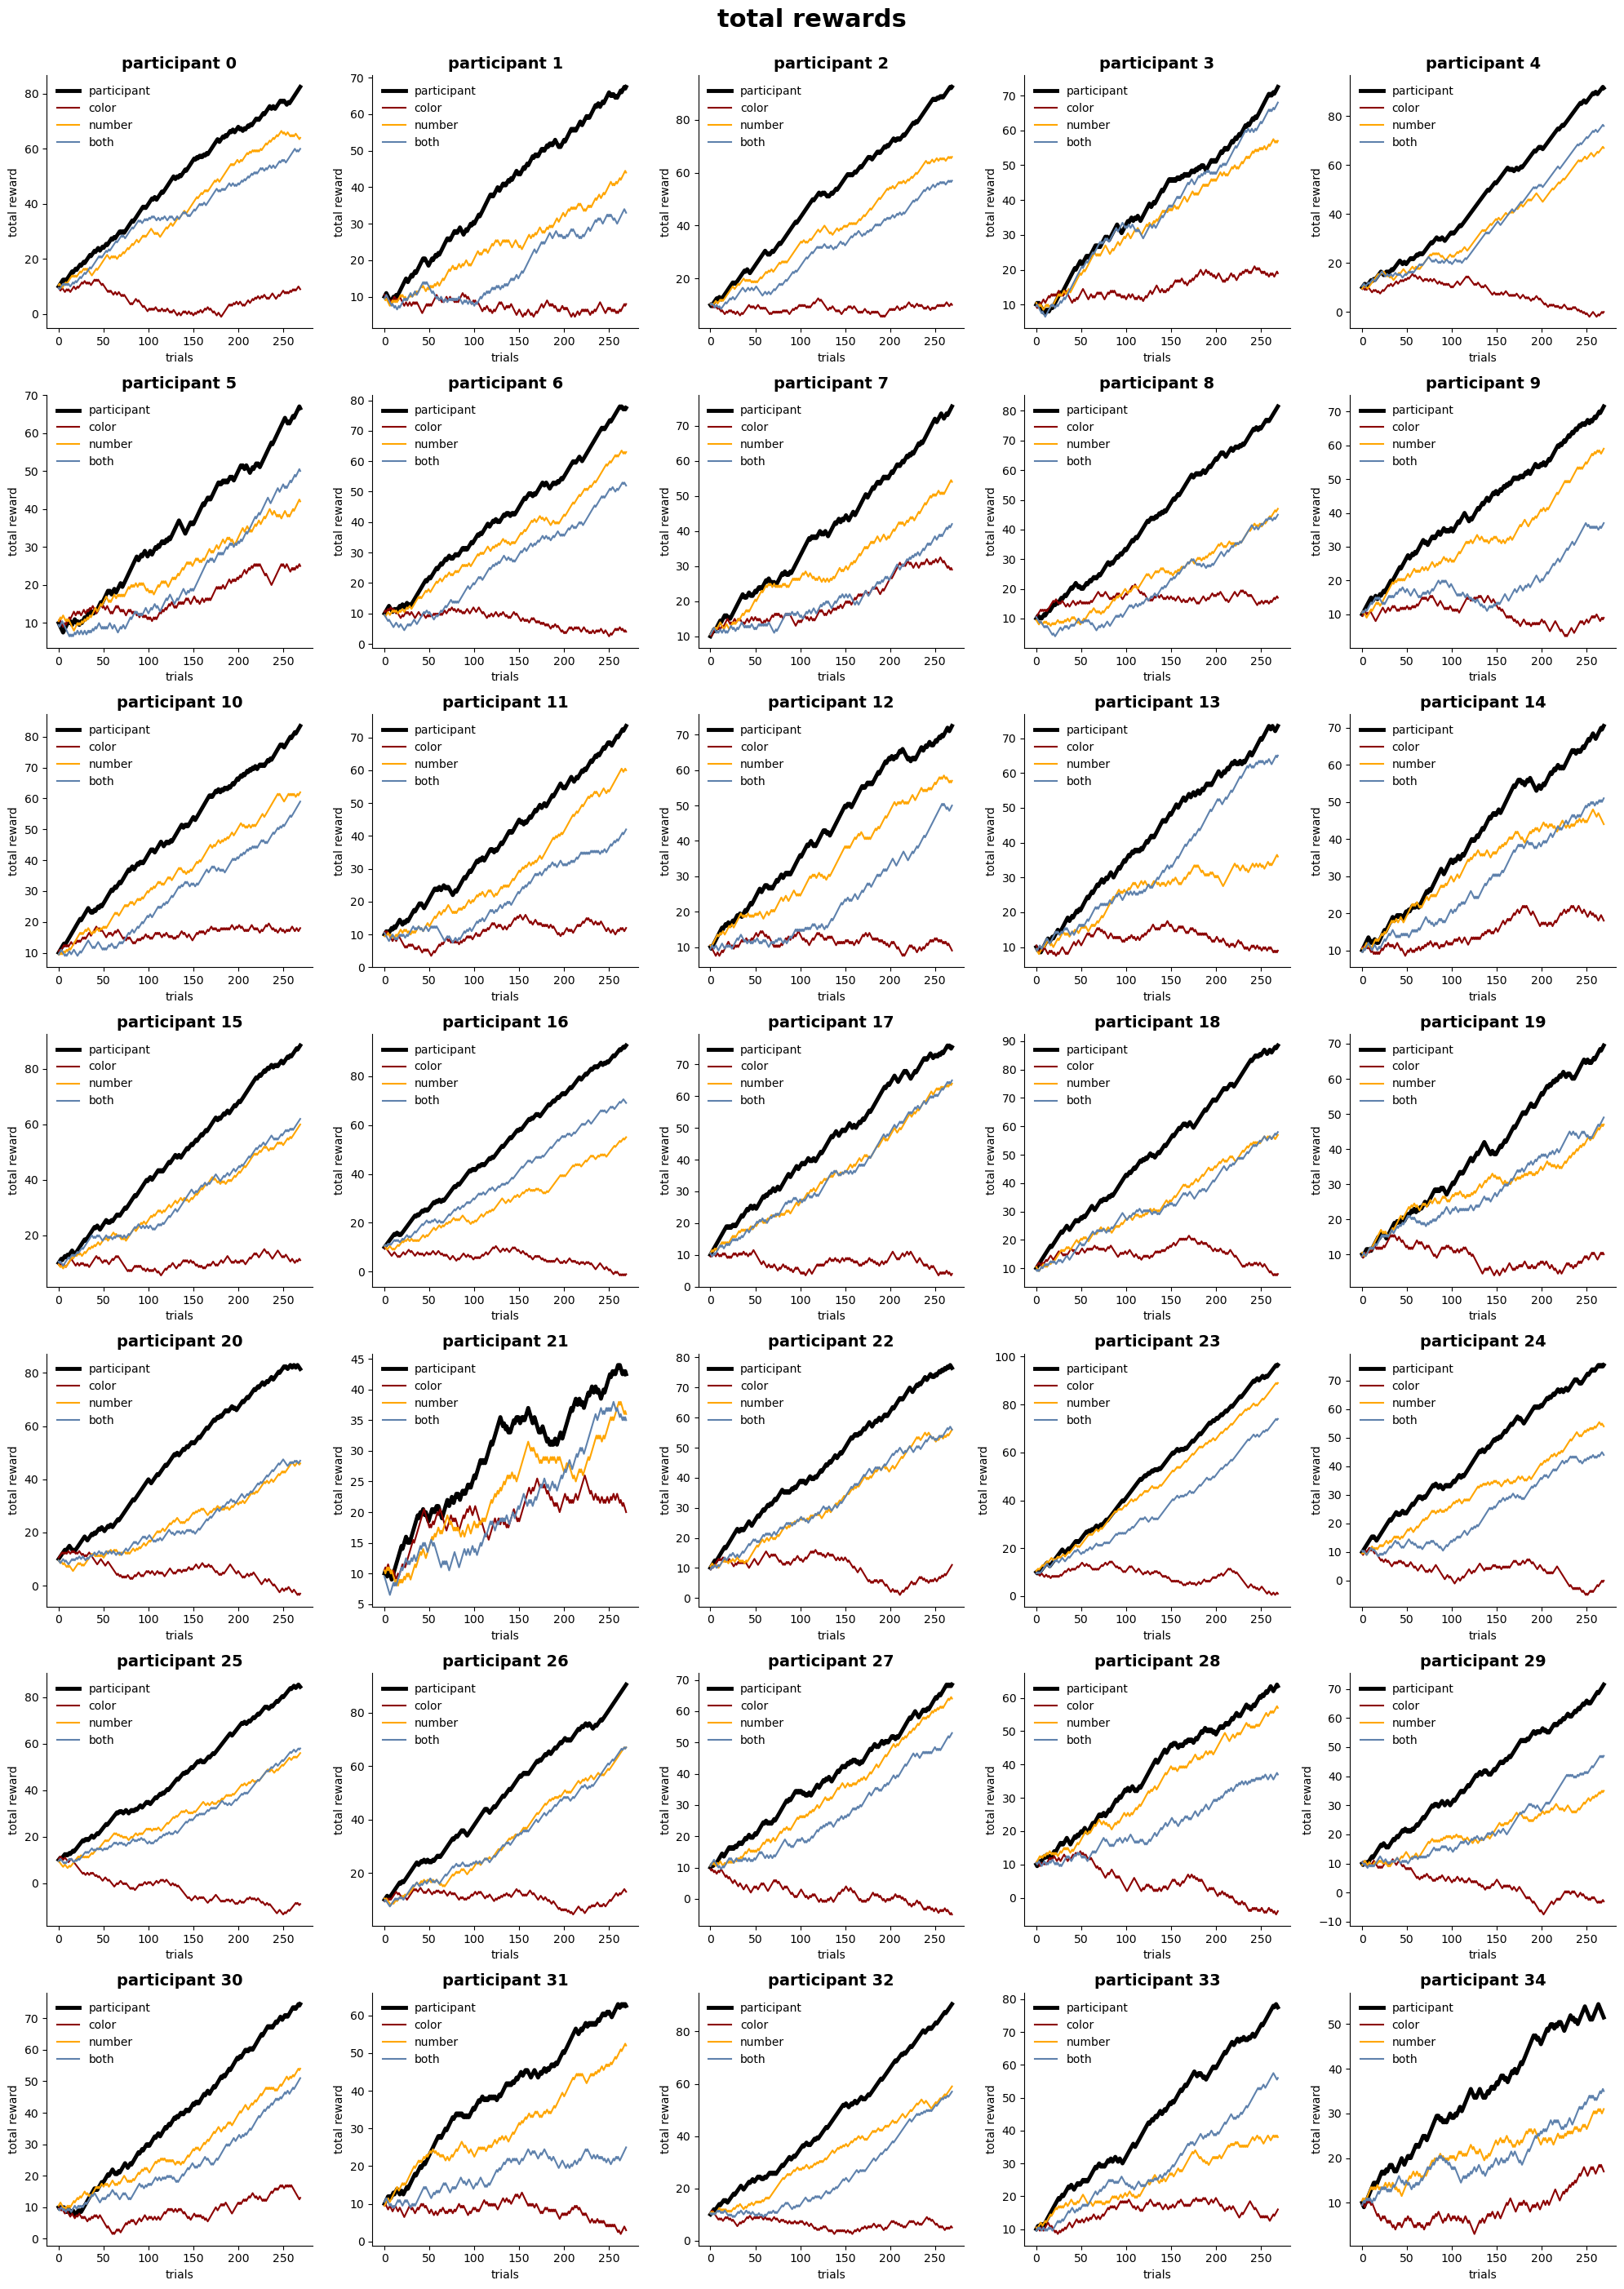

In [10]:
num_subplots = len(df_participants)
trial_num = len(df_participants[0])

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 28))
axes = axes.flatten()


colors = ['black', '#8b0000', 'orange', '#5e81ac']
labels = ['participant', 'color', 'number', 'both']

for i in range(num_subplots):
    ax = axes[i]

    ax.plot(range(trial_num), (df_participants[i]['totalReward'] - df_participants[i]['totalReward'].iloc[0] )+10, label=labels[0], color=colors[0], linewidth=3.5)
    ax.plot(range(trial_num), df_colors[i]['model_total_reward'], label=labels[1], color=colors[1])
    ax.plot(range(trial_num), df_numbers[i]['model_total_reward'], label=labels[2], color=colors[2])
    ax.plot(range(trial_num), df_colors_numbers[i]['model_total_reward'], label=labels[3], color=colors[3])

    ax.set_title(f'participant {i}' , fontsize=14, fontweight='bold')
    ax.set_xlabel('trials')
    ax.set_ylabel('total reward')
    ax.legend(frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for j in range(num_subplots, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle('total rewards', fontsize=22, fontweight='bold', y=1)

plt.tight_layout(rect=[0, 0, 1, 1]) 

filename = os.path.join(output_dir, "total_reward.pdf")
plt.savefig(filename, format='pdf')

# plt.close()


# comparing accuracy in the mix block:

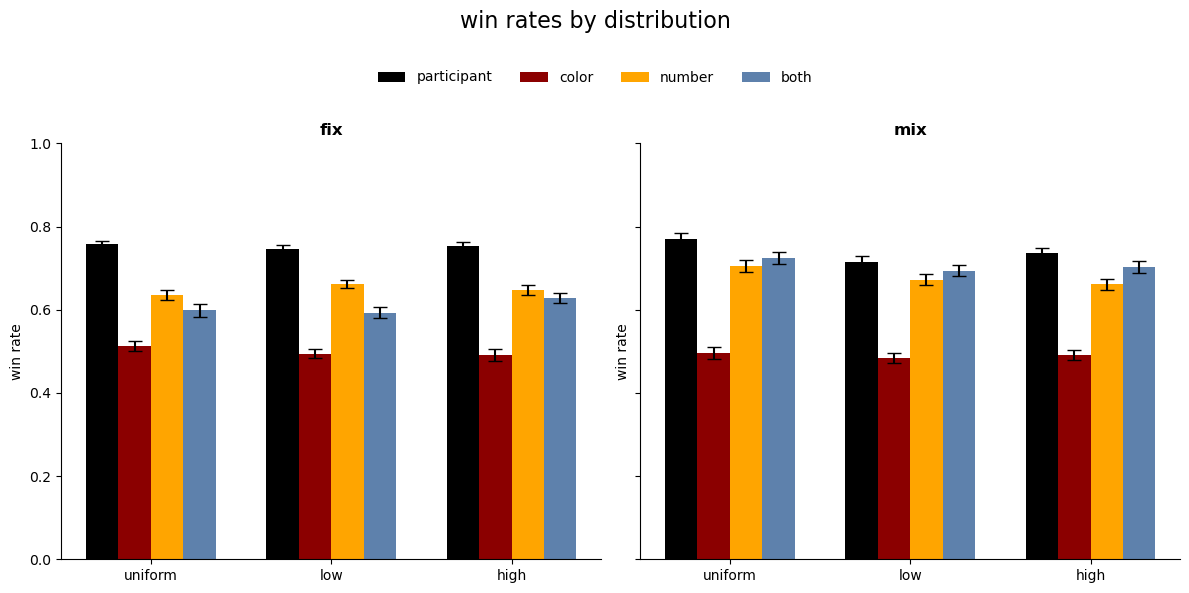

In [11]:
def compute_win_rates_by_block_type(df_list, x_labels=['uniform', 'low', 'high']):
    win_rates_mix = []
    win_rates_non_mix = []

    for df in df_list:
        df['is_win'] = df['outcome'].apply(lambda x: 1 if x == 'win' else 0)

        df_mix = df[df['block_type'] == 'mix']
        df_non_mix = df[df['block_type'] != 'mix']

        if not df_mix.empty:
            total_trials_mix = df_mix.groupby('distribution').size().reset_index(name='total_trials')
            wins_mix = df_mix.groupby('distribution')['is_win'].sum().reset_index(name='wins')
            win_rate_mix = pd.merge(total_trials_mix, wins_mix, on='distribution')
            win_rate_mix['win_rate'] = win_rate_mix['wins'] / win_rate_mix['total_trials']
            win_rates_mix.append(win_rate_mix[['distribution', 'win_rate']])

        if not df_non_mix.empty:
            total_trials_non_mix = df_non_mix.groupby('distribution').size().reset_index(name='total_trials')
            wins_non_mix = df_non_mix.groupby('distribution')['is_win'].sum().reset_index(name='wins')
            win_rate_non_mix = pd.merge(total_trials_non_mix, wins_non_mix, on='distribution')
            win_rate_non_mix['win_rate'] = win_rate_non_mix['wins'] / win_rate_non_mix['total_trials']
            win_rates_non_mix.append(win_rate_non_mix[['distribution', 'win_rate']])

    def compute_group_stats(win_rates_list):
        combined = pd.concat(win_rates_list)
        mean = combined.groupby('distribution')['win_rate'].mean().reset_index()
        std = combined.groupby('distribution')['win_rate'].std().reset_index()
        stats = mean.merge(std, on='distribution', suffixes=('_mean', '_std'))
        stats['distribution'] = pd.Categorical(stats['distribution'], categories=x_labels, ordered=True)
        return stats.sort_values(by='distribution').reset_index(drop=True)

    return compute_group_stats(win_rates_mix), compute_group_stats(win_rates_non_mix), win_rates_mix, win_rates_non_mix



#  participants
mean_win_rates_df_participants_mix, mean_win_rates_df_participants_non_mix, win_rates_mix, win_rates_non_mix = compute_win_rates_by_block_type(df_participants)

#  colors
mean_win_rates_df_colors_mix, mean_win_rates_df_colors_non_mix, win_rates_colors_mix, win_rates_colors_non_mix = compute_win_rates_by_block_type(df_colors)

#  numbers
mean_win_rates_df_numbers_mix, mean_win_rates_df_numbers_non_mix, win_rates_numbers_mix, win_rates_numbers_non_mix = compute_win_rates_by_block_type(df_numbers)

#  both 
mean_win_rates_df_colors_numbers_mix, mean_win_rates_df_colors_numbers_non_mix, win_rates_colors_numbers_mix, win_rates_colors_numbers_non_mix = compute_win_rates_by_block_type(df_colors_numbers)


colors = ['black', '#8b0000', 'orange', '#5e81ac']
labels = ['participant', 'color', 'number', 'both']
x_labels = ['uniform', 'low', 'high']
x = np.arange(len(x_labels))
bar_width = 0.18

def compute_sem(win_rates_list):
    combined = pd.concat(win_rates_list)
    sem = combined.groupby('distribution')['win_rate'].sem().reset_index()
    return sem

mean_dfs_fix = [mean_win_rates_df_participants_non_mix, 
                mean_win_rates_df_colors_non_mix, 
                mean_win_rates_df_numbers_non_mix, 
                mean_win_rates_df_colors_numbers_non_mix]

mean_dfs_mix = [mean_win_rates_df_participants_mix, 
                mean_win_rates_df_colors_mix, 
                mean_win_rates_df_numbers_mix, 
                mean_win_rates_df_colors_numbers_mix]

sem_dfs_fix = [compute_sem(lst) for lst in [win_rates_non_mix, win_rates_colors_non_mix, win_rates_numbers_non_mix, win_rates_colors_numbers_non_mix]]
sem_dfs_mix = [compute_sem(lst) for lst in [win_rates_mix, win_rates_colors_mix, win_rates_numbers_mix, win_rates_colors_numbers_mix]]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

bars = []

for ax_idx, (ax, mean_dfs, sem_dfs, title) in enumerate(zip(
    axes, [mean_dfs_fix, mean_dfs_mix], [sem_dfs_fix, sem_dfs_mix], ['fix', 'mix'])):

    for i, (mean_df, sem_df, color, label) in enumerate(zip(mean_dfs, sem_dfs, colors, labels)):
        means = mean_df['win_rate_mean'].values
        errors = sem_df['win_rate'].values
        bar = ax.bar(x + i * bar_width, means, width=bar_width, label=label, color=color, yerr=errors, capsize=5)
        if ax_idx == 0:
            bars.append(bar[0])

    ax.set_title(f'{title}', fontweight='bold')
    ax.set_xticks(x + 1.5 * bar_width)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('win rate')
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


fig.legend(bars, labels,  loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.9))
plt.suptitle('win rates by distribution', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.88])
filename = os.path.join(output_dir, "win_rates.pdf")
plt.savefig(filename, format='pdf')
plt.show()


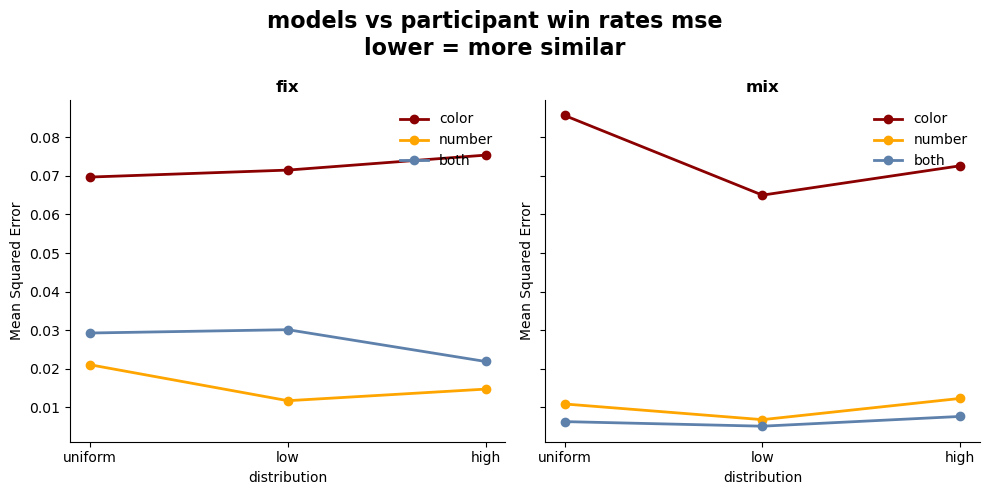

In [12]:
def calculate_mse(participant_win_rates, model_win_rates):
    mse_list = []
    for participant, model in zip(participant_win_rates, model_win_rates):
        merged = pd.merge(participant, model, on='distribution', suffixes=('_participant', '_model'))
        merged['squared_error'] = (merged['win_rate_participant'] - merged['win_rate_model']) ** 2
        mse_list.append(merged[['distribution', 'squared_error']])
    return mse_list

mse_fix = [
    calculate_mse(win_rates_non_mix, win_rates_colors_non_mix),
    calculate_mse(win_rates_non_mix, win_rates_numbers_non_mix),
    calculate_mse(win_rates_non_mix, win_rates_colors_numbers_non_mix)
]

mse_mix = [
    calculate_mse(win_rates_mix, win_rates_colors_mix),
    calculate_mse(win_rates_mix, win_rates_numbers_mix),
    calculate_mse(win_rates_mix, win_rates_colors_numbers_mix)
]

def aggregate_mse(mse_list):
    aggregated = []
    for mse in mse_list:
        combined = pd.concat(mse)
        mean_squared_error = combined.groupby('distribution')['squared_error'].mean().reset_index()
        aggregated.append(mean_squared_error)
    return aggregated

aggregated_fix_mse = aggregate_mse(mse_fix)
aggregated_mix_mse = aggregate_mse(mse_mix)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

colors = ['#8b0000', 'orange', '#5e81ac']
labels = ['color', 'number', 'both']

distribution_order = [ 'uniform', 'low', 'high']

for ax, aggregated, title in zip(axes, [aggregated_fix_mse, aggregated_mix_mse], ['fix', 'mix']):
    for data, color, label in zip(aggregated, colors, labels):
        # Ensure lowercase labels and reorder
        data['distribution'] = data['distribution'].str.lower()
        data = data.set_index('distribution').loc[distribution_order].reset_index()
        ax.plot(data['distribution'], data['squared_error'], marker='o', linewidth=2, color=color, label=label)

    ax.set_title(f'{title}', fontweight='bold')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('distribution')  # lowercase label
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False, loc='upper right')

plt.suptitle('models vs participant win rates mse\nlower = more similar', fontsize=16, fontweight='bold')  # lowercase title
plt.tight_layout()
filename = os.path.join(output_dir, "mse_closeness_win_rates.pdf")
plt.savefig(filename, format='pdf')
plt.show()

# accuracy of different numbers

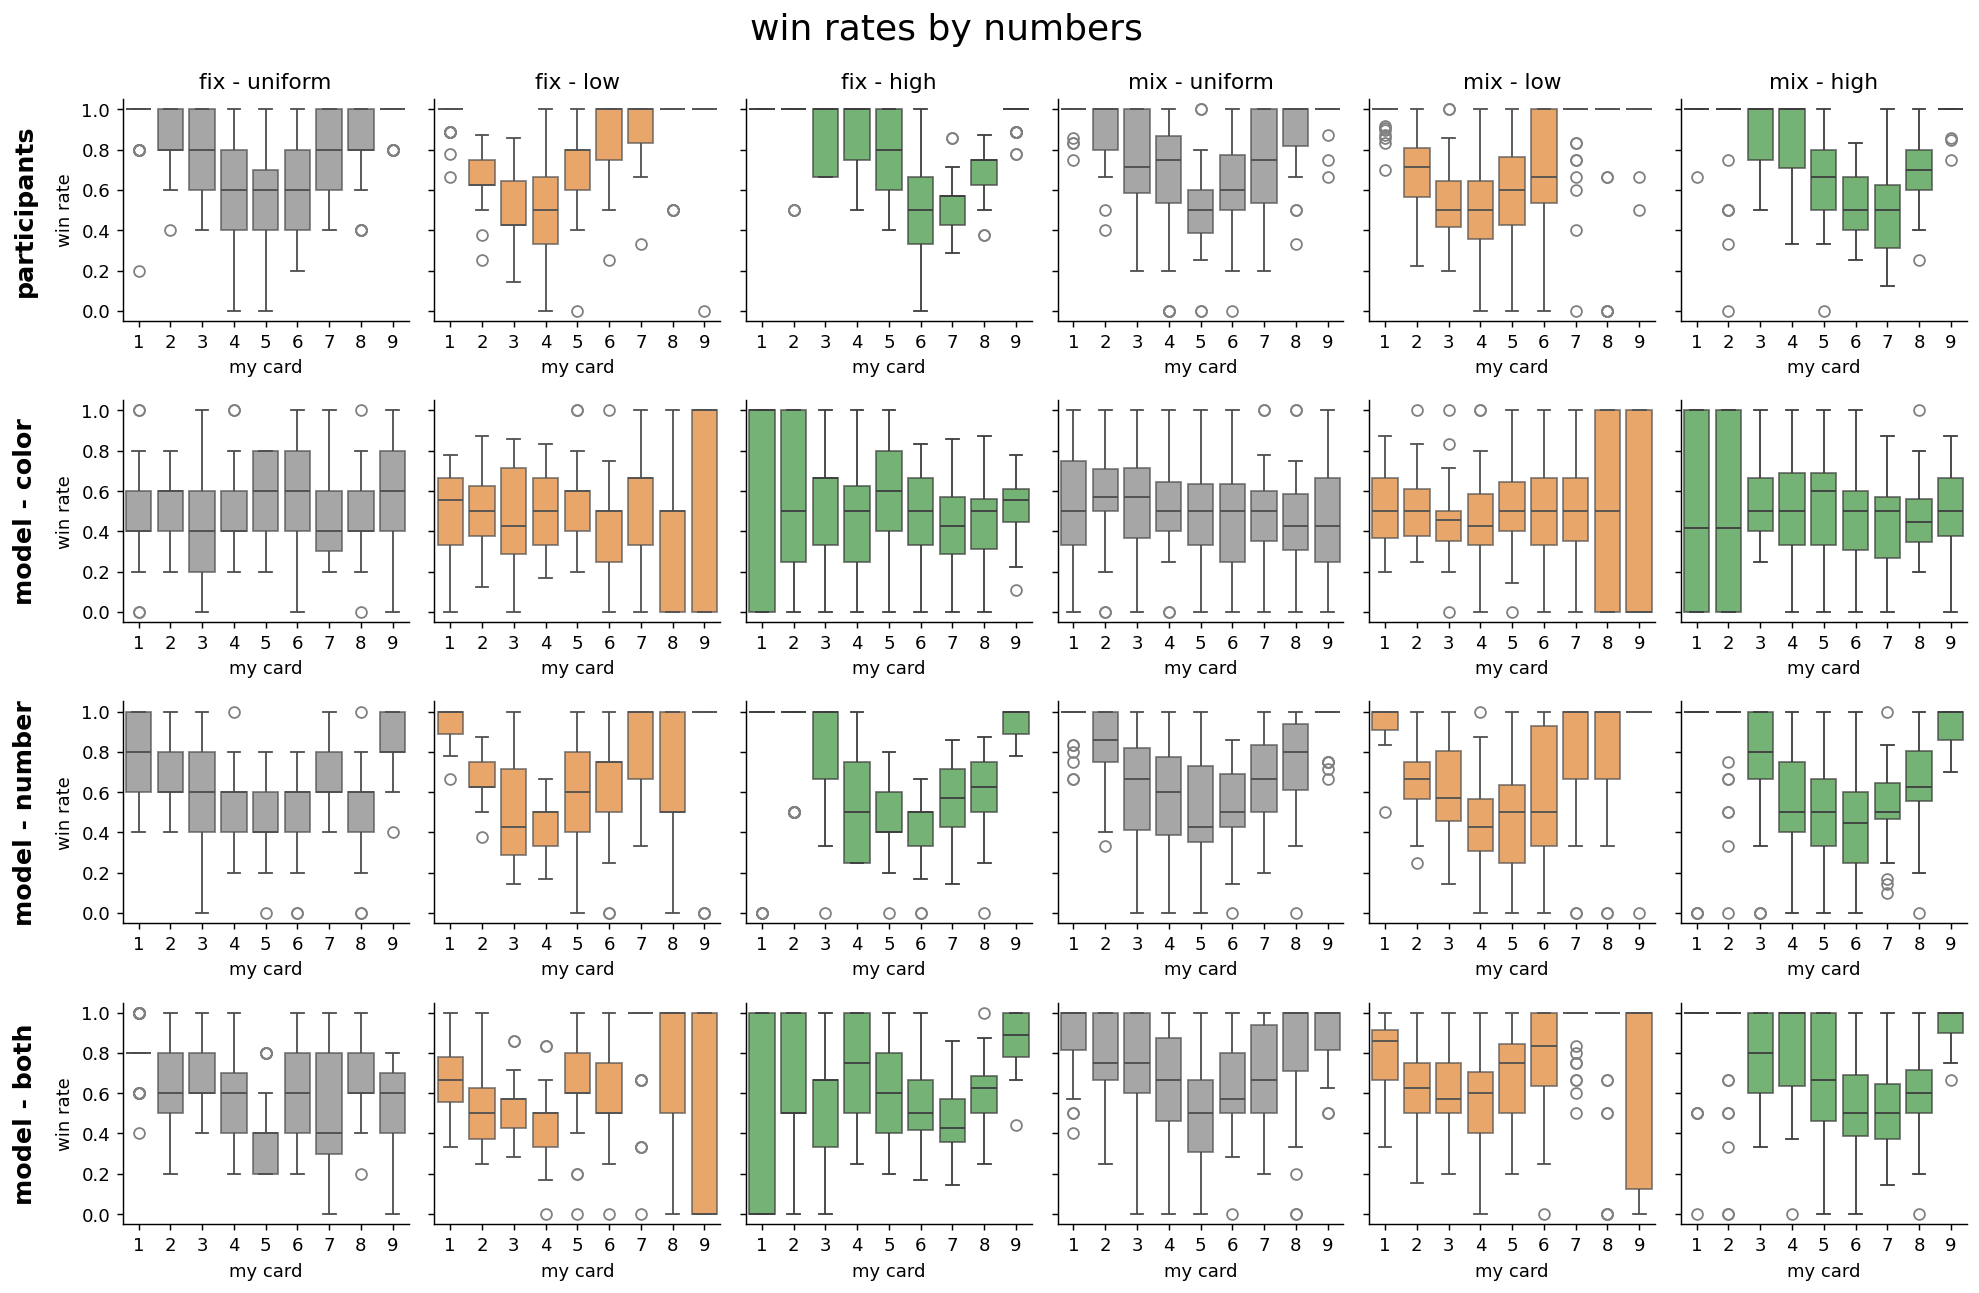

In [13]:
def compute_accuracy_rates(df_list):
    accuracy_fix_all, accuracy_mix_all = [], []
    for df in df_list:
        df['outcome'] = df['outcome'].astype(str)
        df['is_win'] = df['outcome'] == 'win'

        df_mix = df[df['block_type'] == 'mix']
        df_non_mix = df[df['block_type'] != 'mix']

        if not df_mix.empty:
            mix_rate = df_mix.groupby(['myCard', 'distribution'])['is_win'].mean().reset_index()
            mix_rate.rename(columns={'is_win': 'accuracy_rate'}, inplace=True)
            accuracy_mix_all.append(mix_rate)

        if not df_non_mix.empty:
            fix_rate = df_non_mix.groupby(['myCard', 'distribution'])['is_win'].mean().reset_index()
            fix_rate.rename(columns={'is_win': 'accuracy_rate'}, inplace=True)
            accuracy_fix_all.append(fix_rate)

    combined_mix = pd.concat(accuracy_mix_all)
    combined_fix = pd.concat(accuracy_fix_all)

    for df in [combined_mix, combined_fix]:
        df['distribution'] = pd.Categorical(df['distribution'], categories=x_labels, ordered=True)

    return combined_fix, combined_mix

x_labels = ['uniform', 'low', 'high']
color_map = {'uniform': '#808080', 'low': '#ff7f0e', 'high': '#2ca02c'}

datasets = [
    (df_participants, 'participants'),
    (df_colors, 'model - color'),
    (df_numbers, 'model - number'),
    (df_colors_numbers, 'model - both')
]

all_combined_data = [compute_accuracy_rates(ds[0]) + (ds[1],) for ds in datasets] 

fig, axes = plt.subplots(4, 6, figsize=(16, 10), dpi=130, sharey='row')

for row_idx, (combined_fix, combined_mix, row_title) in enumerate(all_combined_data):
    for block_data, block_title, col_offset in zip([combined_fix, combined_mix], ['fix', 'mix'], [0, 3]):
        for dist_idx, dist in enumerate(x_labels):
            ax = axes[row_idx, col_offset + dist_idx]
            subset = block_data[block_data['distribution'] == dist]

            sns.boxplot(
                data=subset,
                x='myCard',
                y='accuracy_rate',
                ax=ax,
                color=color_map[dist],
                boxprops=dict(alpha=0.7),
                flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='gray', markersize=6),
            )

            if row_idx == 0:
                ax.set_title(f'{block_title} - {dist}')
            if dist_idx == 0:
                ax.set_ylabel('win rate')
            else:
                ax.set_ylabel('')

            ax.set_xlabel('my card')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    axes[row_idx, 0].annotate(row_title, xy=(-0.3, 0.5), xycoords='axes fraction',
                              ha='right', va='center', fontsize=14, fontweight='bold', rotation=90)

plt.suptitle('win rates by numbers', fontsize=20, y=0.99)
plt.tight_layout(rect=[0.05, 0, 1, 1])
filename = os.path.join(output_dir, "win_rates_numbers.pdf")
plt.savefig(filename, format='pdf')
plt.show()


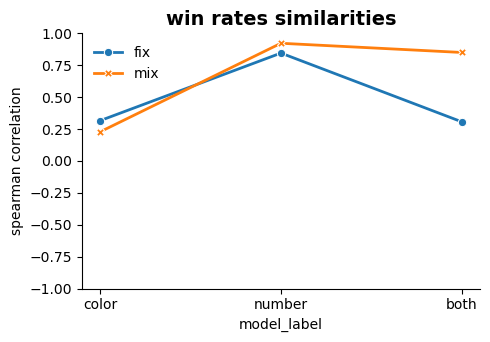

In [14]:
from scipy.stats import spearmanr, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns

def average_rates(df):
    return df.groupby(['myCard', 'distribution'])['accuracy_rate'].mean().unstack()

def compute_spearman(part_df, model_df):
    results = {}
    for dist in part_df.columns:
        r, _ = spearmanr(part_df[dist], model_df[dist])
        results[dist] = r
    return results

# Compute similarities
similarity_fix, similarity_mix = {}, {}
for (fix_df, mix_df, name) in all_combined_data[1:]:  # skip participant
    part_fix = average_rates(all_combined_data[0][0])
    part_mix = average_rates(all_combined_data[0][1])
    model_fix = average_rates(fix_df)
    model_mix = average_rates(mix_df)

    similarity_fix[name] = compute_spearman(part_fix, model_fix)
    similarity_mix[name] = compute_spearman(part_mix, model_mix)

# Convert to DataFrames
df_fix = pd.DataFrame(similarity_fix).T
df_mix = pd.DataFrame(similarity_mix).T

# Average across distributions
df_fix['mean'] = df_fix.mean(axis=1)
df_mix['mean'] = df_mix.mean(axis=1)

# Add participant column
df_fix['participant'] = df_fix.index
df_mix['participant'] = df_mix.index

# Melt for plotting
df_fix_melt = df_fix[['mean', 'participant']].copy()
df_mix_melt = df_mix[['mean', 'participant']].copy()
df_fix_melt['model'] = 'fix'
df_mix_melt['model'] = 'mix'
df_all = pd.concat([df_fix_melt, df_mix_melt])

# Merge with model labels
df_all = df_all.rename(columns={'mean': 'spearman_similarity'})
df_all = df_all.merge(
    pd.DataFrame({'participant': df_fix.index, 'model_label': df_fix.index.str.extract('(color|number|both)')[0]}),
    on='participant'
)

# Plot
plt.figure(figsize=(5, 4))
ax = sns.lineplot(data=df_all, x='model_label', y='spearman_similarity', hue='model',
                  style='model', markers=True, dashes=False, linewidth=2)

# Aesthetics
ax.set_title("win rates similarities", fontsize=14, fontweight='bold')
ax.set_ylabel("spearman correlation")
ax.set_ylim(-1, 1)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[label.lower() for label in labels], frameon=False)

# Add significance markers between fix and mix for each model
for i, model in enumerate(['color', 'number', 'both']):
    fix_vals = df_all[(df_all['model'] == 'fix') & (df_all['model_label'] == model)]['spearman_similarity']
    mix_vals = df_all[(df_all['model'] == 'mix') & (df_all['model_label'] == model)]['spearman_similarity']

    if len(fix_vals) == len(mix_vals) and len(fix_vals) > 1:
        t, p = ttest_rel(fix_vals, mix_vals)
        y_max = max(fix_vals.max(), mix_vals.max())
        ax.plot([i, i], [y_max + 0.05, y_max + 0.08], color='black')
        ax.text(i, y_max + 0.1, '*' if p < 0.05 else 'ns', ha='center', va='bottom', fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.88])
filename = os.path.join(output_dir, "win_rates_numbers_similarities.pdf")
plt.savefig(filename, format='pdf')
plt.show()




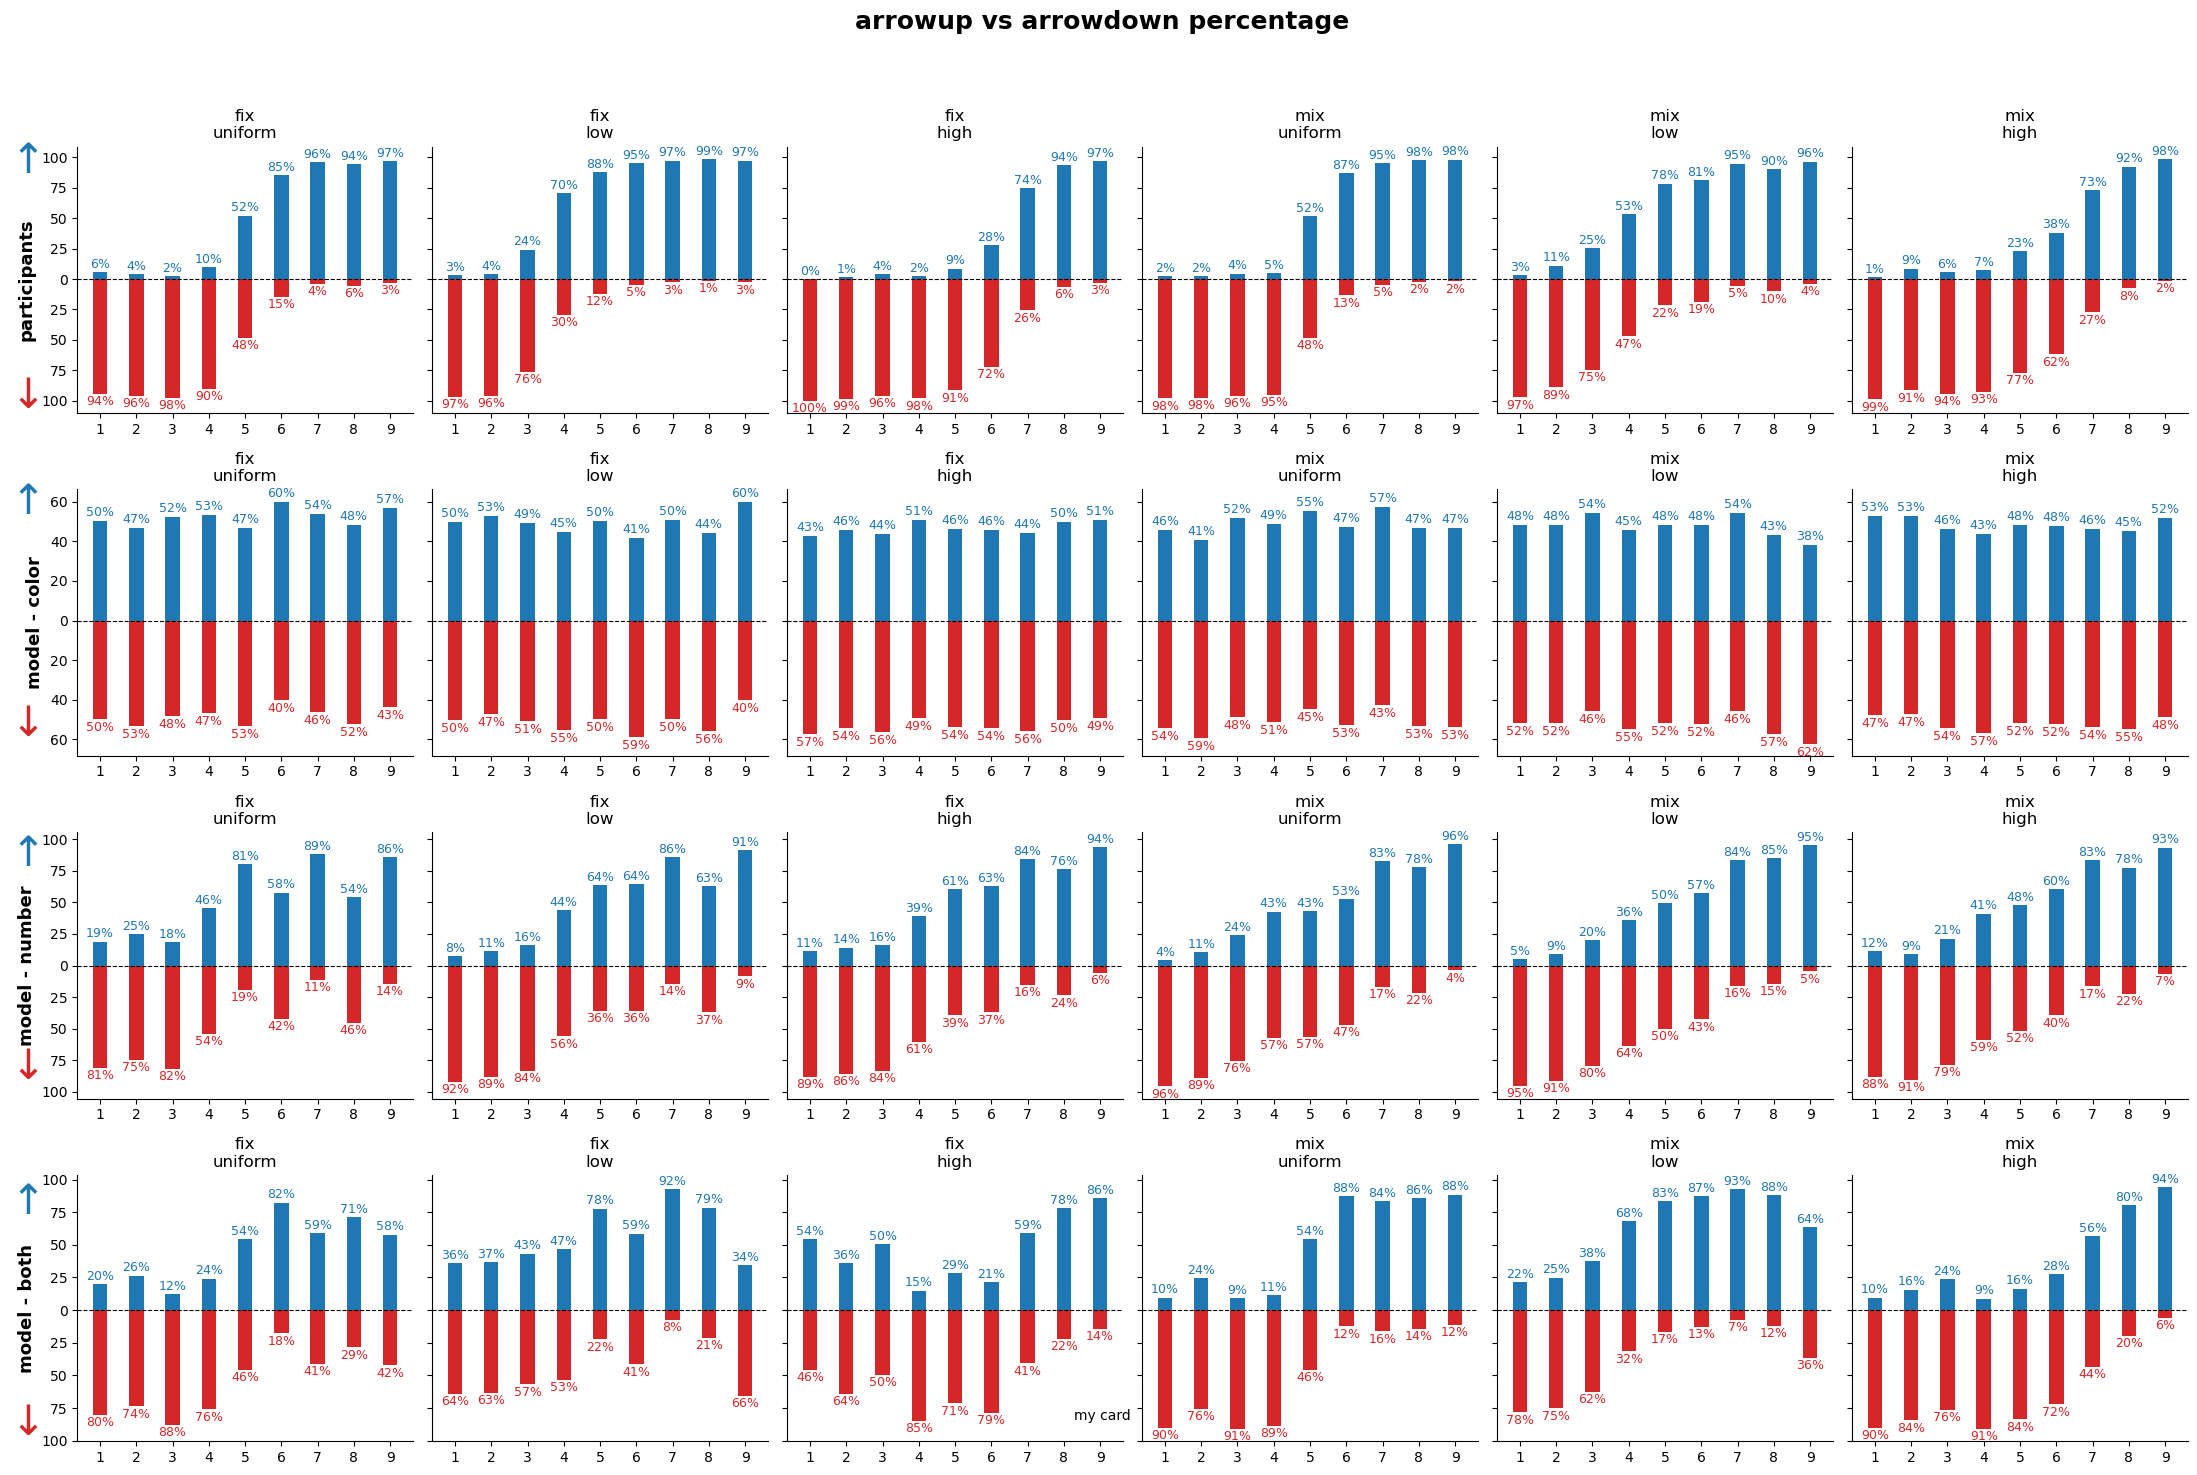

In [15]:
datasets = [
    (df_participants, 'participants', 'choice'),
    (df_colors, 'model - color', 'model_choices'),
    (df_numbers, 'model - number', 'model_choices'),
    (df_colors_numbers, 'model - both', 'model_choices')
]

distributions = ['uniform', 'low', 'high']
plot_data = []

for df_group, group_name, choice_col in datasets:
    for block_type in ['not_mix', 'mix']:
        for dist in distributions:
            group_results = []
            for df in df_group:
                if block_type == 'mix':
                    sub_df = df[(df['block_type'] == 'mix') & (df['distribution'] == dist)].copy()
                else:
                    sub_df = df[(df['block_type'] != 'mix') & (df['distribution'] == dist)].copy()

                sub_df.loc[:, 'group'] = pd.cut(
                    sub_df['myCard'],
                    bins=np.arange(0.5, 10.5, 1),
                    labels=list(range(1, 10))
                )

                if choice_col == 'choice':
                    group_counts = sub_df.groupby(['group', choice_col], observed=True)[choice_col].count().unstack(fill_value=0)
                else:
                    sub_df[choice_col] = sub_df[choice_col].map({1: 'arrowup', 0: 'arrowdown'})
                    group_counts = sub_df.groupby(['group', choice_col], observed=True)[choice_col].count().unstack(fill_value=0)

                group_totals = group_counts.sum(axis=1)
                group_percentages = (group_counts.T / group_totals).T * 100
                group_percentages['group'] = group_percentages.index
                group_results.append(group_percentages.reset_index(drop=True))

            combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()
            plot_data.append((group_name, block_type, dist, combined_results))

fig, axes = plt.subplots(4, 6, figsize=(22, 15), sharey='row')

for i, (group_name, block_type, dist, data) in enumerate(plot_data):
    row = i // 6
    col = i % 6
    ax = axes[row, col]
    groups = data['group']
    arrow_up = data.get('arrowup', 0)
    arrow_down = data.get('arrowdown', 0)
    x = np.arange(len(groups))
    bar_width = 0.4

    bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
    bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

    for j in range(len(x)):
        ax.text(x[j], arrow_up[j] + 1, f'{round(arrow_up[j])}%', ha='center', va='bottom', fontsize=9, color='#1f77b4')
        ax.text(x[j], -arrow_down[j] - 1, f'{round(arrow_down[j])}%', ha='center', va='top', fontsize=9, color='#d62728')

    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    yticks = ax.get_yticks()
    ax.yaxis.set_major_locator(FixedLocator(yticks))
    ax.set_yticklabels([abs(int(t)) if t < 0 else int(t) for t in yticks])

    ax.set_title(f"{'mix' if block_type == 'mix' else 'fix'}\n{dist.lower()}")

    if col == 0:
        ax.text(-2, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=30, ha='center', va='center')
        ax.text(-2, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=30, ha='center', va='center')
        ax.set_ylabel(group_name, fontsize=13, fontweight='bold')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

fig.text(0.5, 0.04, 'my card', ha='center')
fig.suptitle('arrowup vs arrowdown percentage', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
filename = os.path.join(output_dir, "arrowup_arrowdown_percentage.pdf")
plt.savefig(filename, format='pdf')
plt.show()


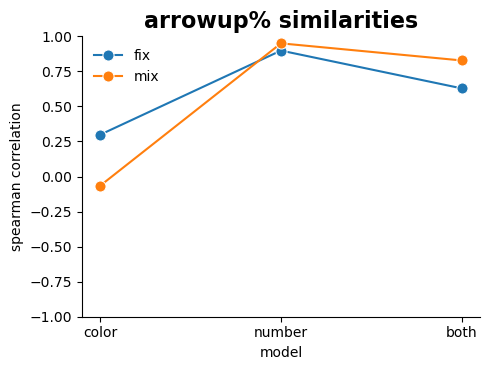

In [16]:

model_labels = ['color', 'number', 'both']
model_names = ['model - color', 'model - number', 'model - both']
block_types = ['not_mix', 'mix']

# Create dicts to collect averaged correlations per model type
corr_fix_avg = []
corr_mix_avg = []

for model_name in model_names:
    fix_corrs = []
    mix_corrs = []
    for dist in ['uniform', 'low', 'high']:
        # Get participant data
        part_fix = [d[3] for d in plot_data if d[0] == 'participants' and d[1] == 'not_mix' and d[2] == dist][0]
        part_mix = [d[3] for d in plot_data if d[0] == 'participants' and d[1] == 'mix' and d[2] == dist][0]

        # Get model data
        model_fix = [d[3] for d in plot_data if d[0] == model_name and d[1] == 'not_mix' and d[2] == dist][0]
        model_mix = [d[3] for d in plot_data if d[0] == model_name and d[1] == 'mix' and d[2] == dist][0]

        # Align and compute Spearman
        merged_fix = pd.merge(part_fix[['group', 'arrowup']], model_fix[['group', 'arrowup']], on='group', suffixes=('_part', '_model'))
        merged_mix = pd.merge(part_mix[['group', 'arrowup']], model_mix[['group', 'arrowup']], on='group', suffixes=('_part', '_model'))

        r_fix, _ = spearmanr(merged_fix['arrowup_part'], merged_fix['arrowup_model'])
        r_mix, _ = spearmanr(merged_mix['arrowup_part'], merged_mix['arrowup_model'])

        fix_corrs.append(r_fix)
        mix_corrs.append(r_mix)

    # Average across distributions
    corr_fix_avg.append(np.mean(fix_corrs))
    corr_mix_avg.append(np.mean(mix_corrs))

# Prepare DataFrame for plotting
df_corr = pd.DataFrame({
    'model_label': model_labels,
    'fix': corr_fix_avg,
    'mix': corr_mix_avg
})

# Melt for plotting
df_corr_melted = df_corr.melt(id_vars='model_label', var_name='block_type', value_name='spearman_corr')

# Plot
plt.figure(figsize=(5, 4)) 
sns.lineplot(data=df_corr_melted, x='model_label', y='spearman_corr', hue='block_type', marker='o', markersize=8)
plt.ylim(-1, 1)

plt.title("arrowup% similarities", fontsize=16, fontweight='bold')
plt.ylabel("spearman correlation")
plt.xlabel("model")

# Customize legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[label.lower() for label in labels], frameon=False, title=None)

# Remove top and right borders
sns.despine()

plt.tight_layout(rect=[0, 0, 1, 0.95])
filename = os.path.join(output_dir, "arrowup_arrowdown_percentage_similarity.pdf")
plt.savefig(filename, format='pdf')
plt.show()

# representational similarity analysis:

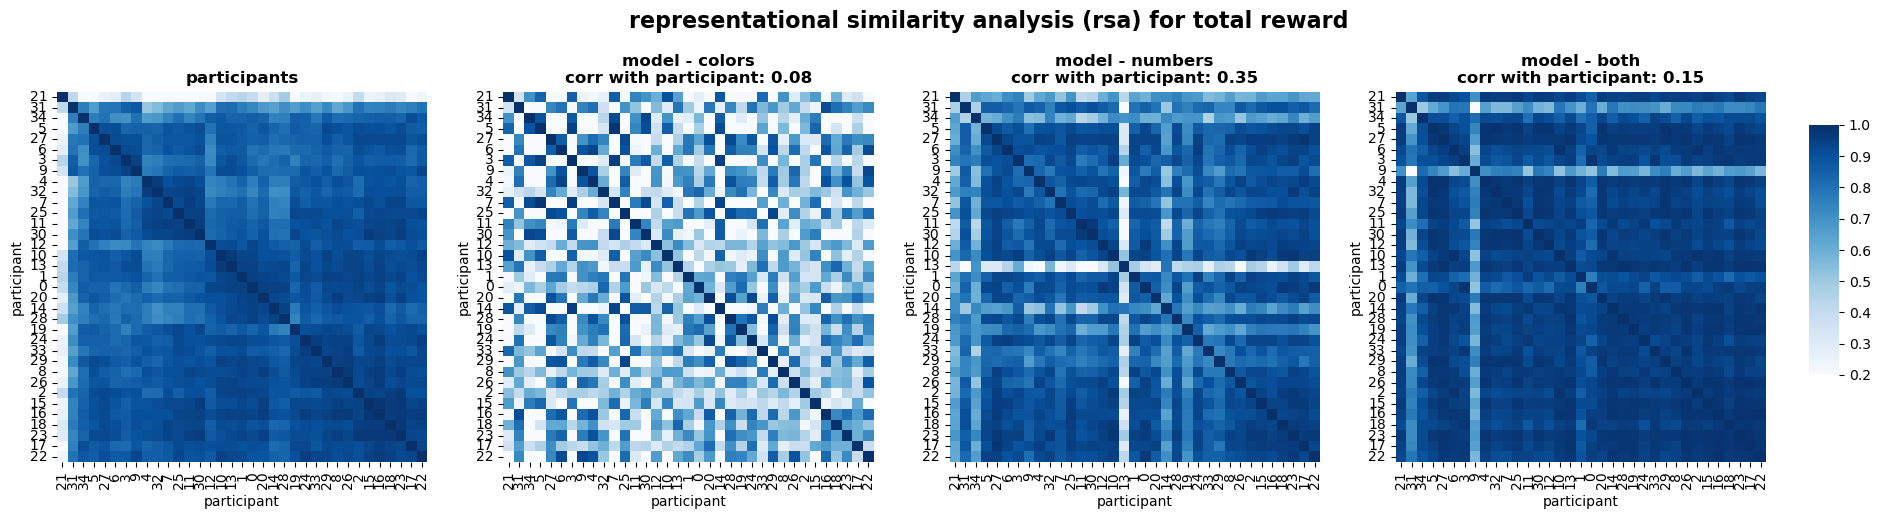

In [17]:
def compute_rsa_matrix_similarity(df_list, key_column):
    num_participants = len(df_list)
    rsa_matrix = np.zeros((num_participants, num_participants))

    for i in range(num_participants):
        for j in range(num_participants):
            reward_i = df_list[i][key_column].values
            reward_j = df_list[j][key_column].values
            distance = correlation(reward_i, reward_j)
            rsa_matrix[i, j] = distance

    max_val = np.max(rsa_matrix)
    min_val = np.min(rsa_matrix)
    similarity_matrix = 1 - (rsa_matrix - min_val) / (max_val - min_val + 1e-8)

    return similarity_matrix

def cluster_rsa_matrix(similarity_matrix):
    dissimilarity = 1 - similarity_matrix
    dissimilarity = (dissimilarity + dissimilarity.T) / 2  
    np.fill_diagonal(dissimilarity, 0)
    linkage_matrix = linkage(squareform(dissimilarity), method='average')
    ordered_indices = leaves_list(linkage_matrix)
    return similarity_matrix[ordered_indices][:, ordered_indices], ordered_indices

rsa_participants_sim = compute_rsa_matrix_similarity(df_participants, 'totalReward')
rsa_participants_sim_clustered, indices_participants = cluster_rsa_matrix(rsa_participants_sim)

rsa_colors_sim = compute_rsa_matrix_similarity(df_colors, 'model_total_reward')
rsa_numbers_sim = compute_rsa_matrix_similarity(df_numbers, 'model_total_reward')
rsa_colors_numbers_sim = compute_rsa_matrix_similarity(df_colors_numbers, 'model_total_reward')

rsa_colors_sim = rsa_colors_sim[indices_participants][:, indices_participants]
rsa_numbers_sim = rsa_numbers_sim[indices_participants][:, indices_participants]
rsa_colors_numbers_sim = rsa_colors_numbers_sim[indices_participants][:, indices_participants]

sim_color = pearsonr(rsa_participants_sim_clustered.flatten(), rsa_colors_sim.flatten())[0]
sim_number = pearsonr(rsa_participants_sim_clustered.flatten(), rsa_numbers_sim.flatten())[0]
sim_both = pearsonr(rsa_participants_sim_clustered.flatten(), rsa_colors_numbers_sim.flatten())[0]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ['participants', 
          f'model - colors\ncorr with participant: {sim_color:.2f}', 
          f'model - numbers\ncorr with participant: {sim_number:.2f}', 
          f'model - both\ncorr with participant: {sim_both:.2f}']
rsa_matrices_sim = [rsa_participants_sim_clustered, rsa_colors_sim, rsa_numbers_sim, rsa_colors_numbers_sim]

cbar_ax = fig.add_axes([0.91, 0.25, 0.015, 0.5])
vmin, vmax = 0.2, 1
labels = [str(i).lower() for i in indices_participants]

for ax, rsa_matrix, title in zip(axes, rsa_matrices_sim, titles):
    sns.heatmap(
        rsa_matrix,
        ax=ax,
        cmap='Blues',  # single color scale
        cbar=(ax == axes[-1]),
        cbar_ax=None if ax != axes[-1] else cbar_ax,
        square=True,
        vmin=vmin,
        vmax=vmax,
        annot=False,
        xticklabels=labels,
        yticklabels=labels
    )
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('participant')
    ax.set_ylabel('participant')

plt.suptitle('representational similarity analysis (rsa) for total reward', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # adjusted for new colorbar position

filename = os.path.join(output_dir, "rsa_total_reward.pdf")
plt.savefig(filename, format='pdf')
plt.show()


# RSA total reward fix and mix

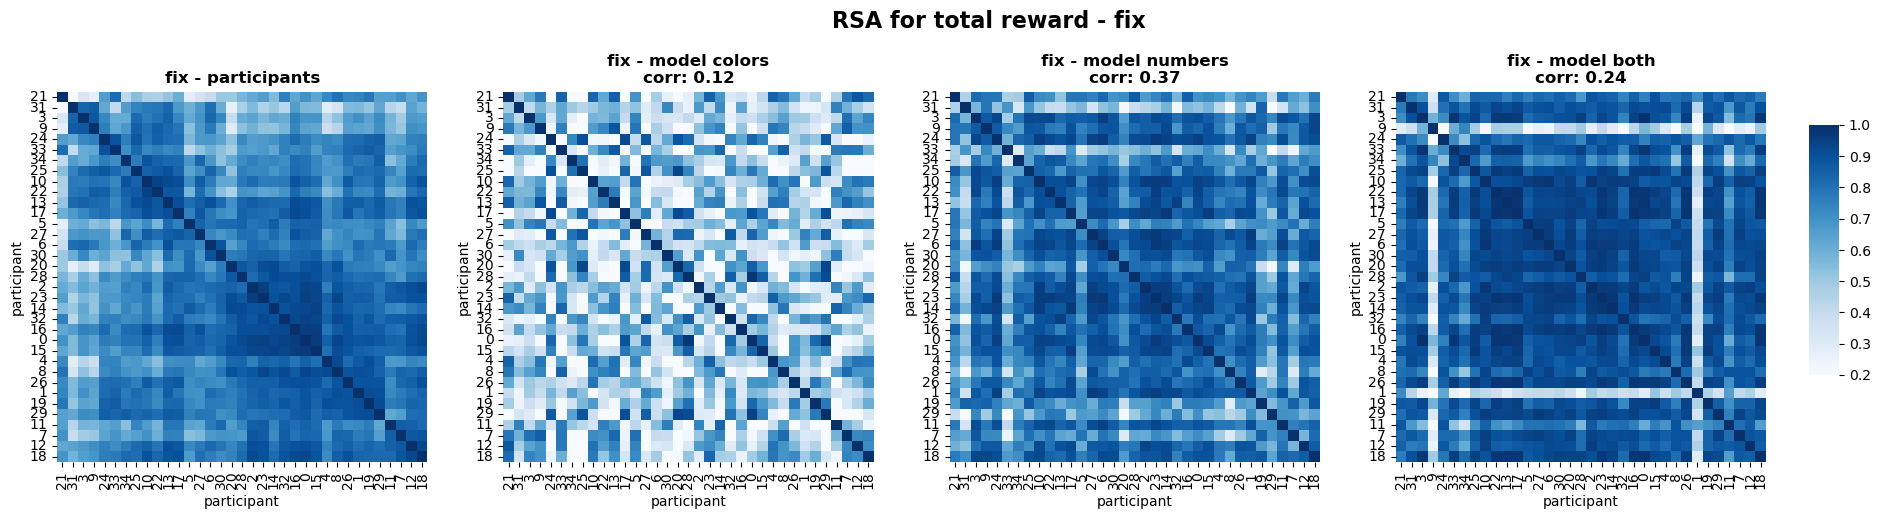

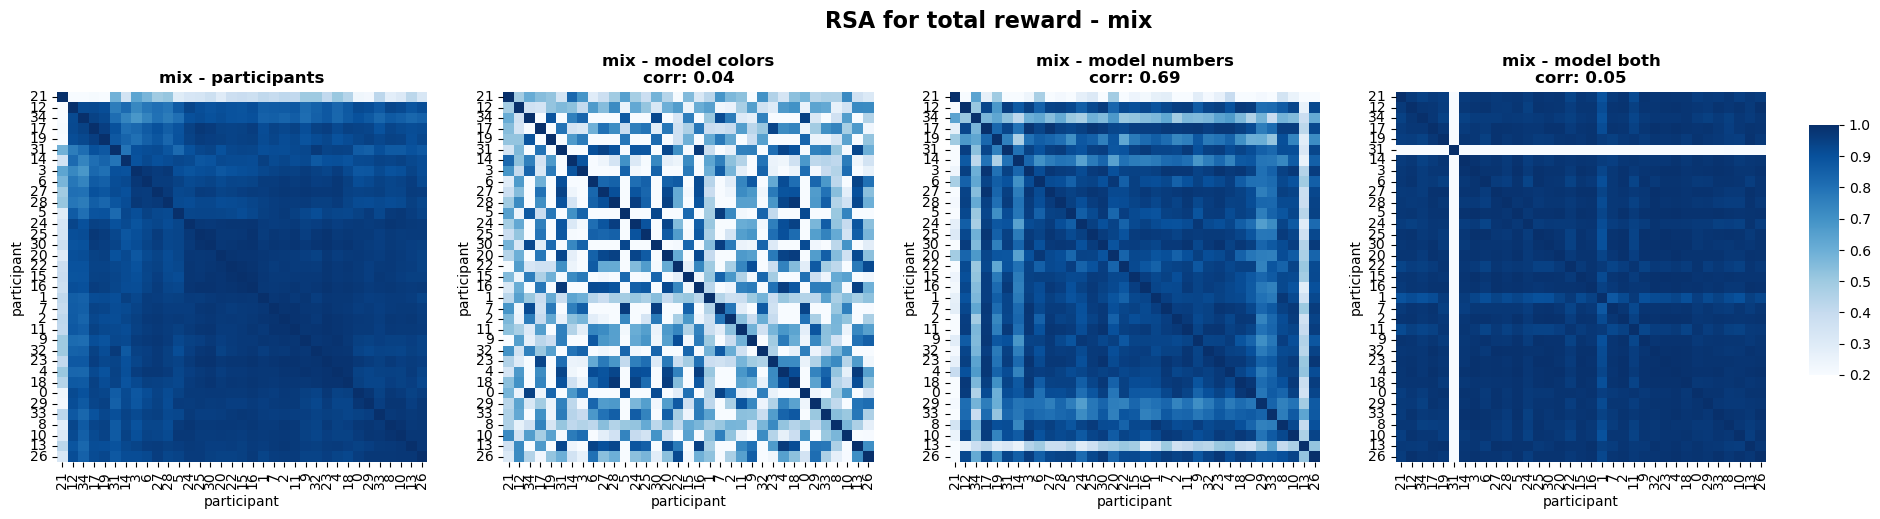

In [18]:
def split_df_list(df_list):
    df_list_fix = []
    df_list_mix = []
    for df in df_list:
        midpoint = len(df) // 2
        df_list_fix.append(df.iloc[:midpoint])
        df_list_mix.append(df.iloc[midpoint:])
    return df_list_fix, df_list_mix

# Split all dataframes into fix and mix halves
df_participants_fix, df_participants_mix = split_df_list(df_participants)
df_colors_fix, df_colors_mix = split_df_list(df_colors)
df_numbers_fix, df_numbers_mix = split_df_list(df_numbers)
df_colors_numbers_fix, df_colors_numbers_mix = split_df_list(df_colors_numbers)

# Run RSA and clustering on fix
rsa_fix_sim = compute_rsa_matrix_similarity(df_participants_fix, 'totalReward')
rsa_fix_clustered, indices_fix = cluster_rsa_matrix(rsa_fix_sim)

rsa_colors_fix = compute_rsa_matrix_similarity(df_colors_fix, 'model_total_reward')
rsa_numbers_fix = compute_rsa_matrix_similarity(df_numbers_fix, 'model_total_reward')
rsa_colors_numbers_fix = compute_rsa_matrix_similarity(df_colors_numbers_fix, 'model_total_reward')

rsa_colors_fix = rsa_colors_fix[indices_fix][:, indices_fix]
rsa_numbers_fix = rsa_numbers_fix[indices_fix][:, indices_fix]
rsa_colors_numbers_fix = rsa_colors_numbers_fix[indices_fix][:, indices_fix]

# Run RSA and clustering on mix
rsa_mix_sim = compute_rsa_matrix_similarity(df_participants_mix, 'totalReward')
rsa_mix_clustered, indices_mix = cluster_rsa_matrix(rsa_mix_sim)

rsa_colors_mix = compute_rsa_matrix_similarity(df_colors_mix, 'model_total_reward')
rsa_numbers_mix = compute_rsa_matrix_similarity(df_numbers_mix, 'model_total_reward')
rsa_colors_numbers_mix = compute_rsa_matrix_similarity(df_colors_numbers_mix, 'model_total_reward')

rsa_colors_mix = rsa_colors_mix[indices_mix][:, indices_mix]
rsa_numbers_mix = rsa_numbers_mix[indices_mix][:, indices_mix]
rsa_colors_numbers_mix = rsa_colors_numbers_mix[indices_mix][:, indices_mix]

# Correlations (fix)
sim_color_fix = pearsonr(rsa_fix_clustered.flatten(), rsa_colors_fix.flatten())[0]
sim_number_fix = pearsonr(rsa_fix_clustered.flatten(), rsa_numbers_fix.flatten())[0]
sim_both_fix = pearsonr(rsa_fix_clustered.flatten(), rsa_colors_numbers_fix.flatten())[0]

# Correlations (mix)
sim_color_mix = pearsonr(rsa_mix_clustered.flatten(), rsa_colors_mix.flatten())[0]
sim_number_mix = pearsonr(rsa_mix_clustered.flatten(), rsa_numbers_mix.flatten())[0]
sim_both_mix = pearsonr(rsa_mix_clustered.flatten(), rsa_colors_numbers_mix.flatten())[0]

# Plot fix and mix side by side
for stage, sim_part, sim_color, sim_number, sim_both, color_mat, number_mat, both_mat, indices in [
    ("fix", rsa_fix_clustered, sim_color_fix, sim_number_fix, sim_both_fix, rsa_colors_fix, rsa_numbers_fix, rsa_colors_numbers_fix, indices_fix),
    ("mix", rsa_mix_clustered, sim_color_mix, sim_number_mix, sim_both_mix, rsa_colors_mix, rsa_numbers_mix, rsa_colors_numbers_mix, indices_mix)
]:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    titles = [
        f'{stage} - participants',
        f'{stage} - model colors\ncorr: {sim_color:.2f}',
        f'{stage} - model numbers\ncorr: {sim_number:.2f}',
        f'{stage} - model both\ncorr: {sim_both:.2f}'
    ]
    rsa_matrices_sim = [sim_part, color_mat, number_mat, both_mat]

    cbar_ax = fig.add_axes([0.91, 0.25, 0.015, 0.5])
    vmin, vmax = 0.2, 1
    labels = [str(i).lower() for i in indices]

    for ax, rsa_matrix, title in zip(axes, rsa_matrices_sim, titles):
        sns.heatmap(
            rsa_matrix,
            ax=ax,
            cmap='Blues',
            cbar=(ax == axes[-1]),
            cbar_ax=None if ax != axes[-1] else cbar_ax,
            square=True,
            vmin=vmin,
            vmax=vmax,
            annot=False,
            xticklabels=labels,
            yticklabels=labels
        )
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('participant')
        ax.set_ylabel('participant')

    plt.suptitle(f'RSA for total reward - {stage}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    filename = os.path.join(output_dir, f"rsa_total_reward_{stage}.pdf")
    plt.savefig(filename, format='pdf')
    plt.show()
